# Time Series Forecasting with LSTMs #

## Using the Beijing PM2.5 dataset to predict the air quality ##

In [41]:
#Importing the libraries
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Preparing the raw data ###

#### Consolidating the date-time information into a single date-time so that we can use it as an index in Pandas.
#### There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values.


In [42]:
#loading the dataset
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('raw.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col = 0, date_parser = parse)
dataset.drop('No', axis=1, inplace=True)
#Specifying column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
#removing the NA values
dataset['pollution'].fillna(0, inplace=True)
#dropiing the first 24 hrs as they have negative values
dataset = dataset[24:]
print(dataset.head())


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [43]:
#Saving the new dataset
dataset.to_csv('pollution.csv')

### Plotting each series as a separate subplot ###

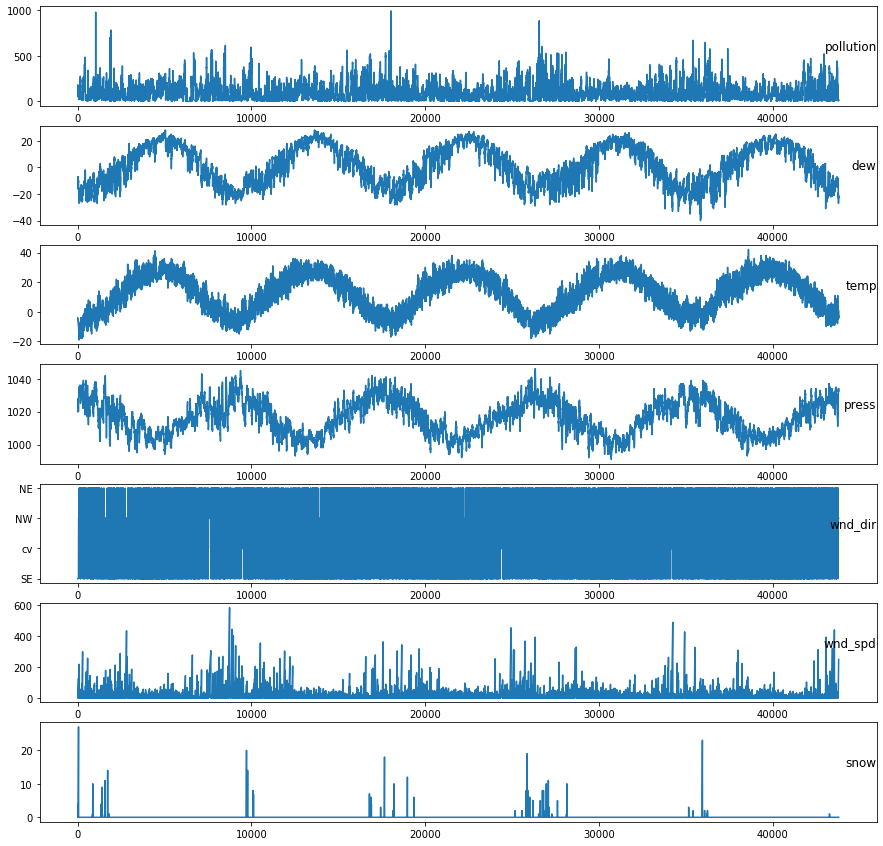

In [44]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
#specify columns to plot
grps = [0, 1, 2, 3, 4, 5, 6]
i = 1
#Plotting each item
plt.figure(figsize=([15, 15]))
for group in grps:
    plt.subplot(len(grps), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### It creates a plot with 7 subplots showing the 5 years of data for each feature except wind dir, which is categorical. ###

## Converting Series into supervised learning problem ##

In [45]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#### We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [46]:
#load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
#Label encoding direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
#converting all data to float
values = values.astype('float32')
#Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#frame as supervised learning
framed = series_to_supervised(scaled, 1, 1)
#Drop coloumns we don't want to predict
framed.drop(framed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
framed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


## Preparing our model ##

In [47]:
#splitting into training and testing sets
values = framed.values
n_train_hours = 365 * 24
train = values[: n_train_hours, :]
test = values[n_train_hours:, :]
#split into input and output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#reshaping input to be 3-D by adding timesteps required by the LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


#### The LSTM will contain 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

#### We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

#### The model will be fit for 50 training epochs with a batch size of 72. 

Epoch 1/50
122/122 - 4s - loss: 0.0603 - val_loss: 0.0588
Epoch 2/50
122/122 - 1s - loss: 0.0408 - val_loss: 0.0617
Epoch 3/50
122/122 - 1s - loss: 0.0254 - val_loss: 0.0478
Epoch 4/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0397
Epoch 5/50
122/122 - 1s - loss: 0.0159 - val_loss: 0.0267
Epoch 6/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0186
Epoch 7/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0169
Epoch 8/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0161
Epoch 9/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0158
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0151
Epoch 11/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 13/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 14/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 15/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0142
Epoch 16/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0148
Epoch 17/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0144
Epoch 

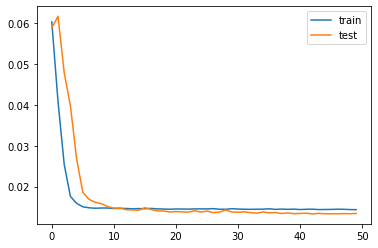

Test RMSE: 26.411


In [48]:
#Designing and fitting our LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### As it appears test loss drops below training loss. The model may be overfitting the training data. Measuring and plotting RMSE during training may be helpful.
####  Results may vary given the stochastic nature of the algorithm or evaluation procedure.

##  Now let's train our model on multiple lag timestamps.



#### Before calling series_to_supervised(), we will use 3 hours of data as input and we will longer explictly drop the columns from all of the other fields at obs(t).

In [50]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3                           # These are the 2 new lines added
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 32)


#### Training and Testing 

In [51]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


#### Designing and fitting our model

Epoch 1/50
122/122 - 4s - loss: 0.0442 - val_loss: 0.0439
Epoch 2/50
122/122 - 2s - loss: 0.0228 - val_loss: 0.0213
Epoch 3/50
122/122 - 2s - loss: 0.0215 - val_loss: 0.0201
Epoch 4/50
122/122 - 1s - loss: 0.0205 - val_loss: 0.0191
Epoch 5/50
122/122 - 2s - loss: 0.0202 - val_loss: 0.0190
Epoch 6/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0187
Epoch 7/50
122/122 - 2s - loss: 0.0191 - val_loss: 0.0185
Epoch 8/50
122/122 - 1s - loss: 0.0188 - val_loss: 0.0179
Epoch 9/50
122/122 - 1s - loss: 0.0184 - val_loss: 0.0181
Epoch 10/50
122/122 - 1s - loss: 0.0179 - val_loss: 0.0175
Epoch 11/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0176
Epoch 12/50
122/122 - 2s - loss: 0.0172 - val_loss: 0.0177
Epoch 13/50
122/122 - 2s - loss: 0.0169 - val_loss: 0.0177
Epoch 14/50
122/122 - 2s - loss: 0.0164 - val_loss: 0.0179
Epoch 15/50
122/122 - 1s - loss: 0.0161 - val_loss: 0.0174
Epoch 16/50
122/122 - 1s - loss: 0.0156 - val_loss: 0.0171
Epoch 17/50
122/122 - 2s - loss: 0.0155 - val_loss: 0.0182
Epoch 

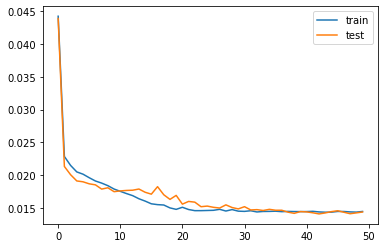

Test RMSE: 26.721


In [52]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#####  the model achieves a respectable RMSE of 26.721, which is lower than an RMSE of 30 found with a persistence model.



## As we can see there is no major difference in the 2 graphs. The test RMSE is not showing any significant advantage in skill.